# Project WeRateDogs

##### Importing Libraries

In [722]:
import pandas as pd

In [723]:
import numpy as np

In [724]:
import json

In [725]:
import os

In [726]:
import requests

In [727]:
from io import BytesIO

In [728]:
from PIL import Image

In [729]:
import re

In [730]:
%matplotlib inline

In [731]:
import matplotlib as plt

## First Step: Gathering Data

##### adding The WeRateDogs Twitter archive to data frame(archive_df)

In [732]:
archive_df = pd.read_csv("twitter-archive-enhanced.csv")

In [733]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


##### adding The WeRateDogs Twitter images to data frame(image_df)

In [734]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [735]:
r = requests.get(url)

In [736]:
with open('image_predictions.tsv',mode='wb') as file:
    file.write(r.content)

In [737]:
image_df = pd.read_csv('image_predictions.tsv' , sep ="\t")

In [738]:
image_df.head()


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


##### adding The WeRateDogs tweet_id,retweet count,favorite count to data frame(tweet_df)

In [739]:
tweet_list = []

In [740]:
with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        id_str = tweet['id_str']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        tweet_list.append({'tweet_id':id_str , 'retweet_count': retweet_count , 'favorite_count': favorite_count})
        tweet_df = pd.DataFrame(tweet_list, columns = ['tweet_id','retweet_count','favorite_count'])

In [741]:
tweet_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Second Step: Assessing Data

##### Assessing archive_df visually and programmatically for quality and tidiness issues

In [742]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [743]:
archive_df.expanded_urls.isnull().sum()

59

In [744]:
archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1270,709449600415961088,NaN,NaN,2016-03-14 18:42:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Karma. She's just a head. Lost body durin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/709449600...,10,10,Karma,None,None,None,None
1713,680473011644985345,NaN,NaN,2015-12-25 19:39:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Hector. He thinks he's a hammer. Silly...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680473011...,10,10,Hector,None,None,pupper,None
984,749317047558017024,NaN,NaN,2016-07-02 19:01:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Blu. He's a wild bush Floofer. I wish ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749317047...,12,10,Blu,None,floofer,None,None
2161,669564461267722241,NaN,NaN,2015-11-25 17:13:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Coriander Baton Rouge named Alfredo....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669564461...,10,10,a,None,None,None,None
2141,669993076832759809,NaN,NaN,2015-11-26 21:36:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. Her dreams of becoming a hippo b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669993076...,9,10,Zoey,None,None,None,None


In [745]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [746]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [747]:
archive_df.duplicated().sum()

0

In [748]:
archive_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

##### 1 - Tidiness issues

    *values are columns names(doggo, floofer, pupper and puppo)

##### 2 - Quality Issues

    *Consistency issues:
        *Tweet ID column type is int
        *Timestamp column type is object
        *columns retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id and in_reply_to_user_id that have to be deleted as per the data wrangling scope defined in the project specification
        *Null values in expanded_urls column
        *In expanded_url column of the archive_df, there are missing values for tweets without photos so those entries can be dropped safely.

    *Completeness issues:
        *the tweets with no images as the number of tweets for the archive_df dataset and the image_prediction_df doenot match
        *Some tweets are actually retweets and replies not original tweets that have to be deleted as per the data wrangling scope mandated by the project specification

    *Accuracy issues:
        *Incorrect and weird values in column rating numerator
        *invalid names in names column

##### Assessing image_df visually and programmatically for quality and tidiness issues

In [749]:
image_df.to_csv ('image_df.csv', index = False, header=True)

In [750]:
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [751]:
image_df.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
100,667782464991965184,https://pbs.twimg.com/media/CURwm3cUkAARcO6.jpg,1,lorikeet,0.466149,False,hummingbird,0.083011,False,African_grey,0.054247,False
1713,818614493328580609,https://pbs.twimg.com/media/C1xNgraVIAA3EVb.jpg,4,Chihuahua,0.450722,True,Border_terrier,0.204177,True,beagle,0.092774,True
611,680115823365742593,https://pbs.twimg.com/media/CXBBurSWMAELewi.jpg,1,pug,0.999365,True,French_bulldog,0.000544,True,Boston_bull,0.000028,True
1229,745433870967832576,https://pbs.twimg.com/media/ClhQJUUWAAEVpBX.jpg,1,barrow,0.999962,False,basset,0.000014,True,wok,0.000006,False
167,668986018524233728,https://pbs.twimg.com/media/CUi3PIrWoAAPvPT.jpg,1,doormat,0.976103,False,Chihuahua,0.005640,True,Norfolk_terrier,0.003913,True
68,667182792070062081,https://pbs.twimg.com/media/CUJPNjOWsAAZRqP.jpg,1,golden_retriever,0.949892,True,Irish_setter,0.010564,True,Chesapeake_Bay_retriever,0.005821,True
569,678389028614488064,https://pbs.twimg.com/media/CWofOHUWUAACGVa.jpg,1,miniature_pinscher,0.516284,True,kelpie,0.227402,True,vizsla,0.103246,True
658,682389078323662849,https://pbs.twimg.com/media/CXhVKtvW8AAyiyK.jpg,1,curly-coated_retriever,0.482288,True,flat-coated_retriever,0.315286,True,Great_Dane,0.062179,True
150,668641109086707712,https://pbs.twimg.com/media/CUd9ivxWUAAuXSQ.jpg,1,vacuum,0.432594,False,pug,0.146311,True,toilet_tissue,0.024500,False
836,694206574471057408,https://pbs.twimg.com/media/CaJRMPQWIAA1zL9.jpg,1,Shih-Tzu,0.352547,True,toy_poodle,0.155720,True,Maltese_dog,0.116657,True


In [752]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [753]:
image_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [754]:
image_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [755]:
image_df.duplicated().sum()

0

##### 1 - Tidiness

    *There are many tidiness issues as the Column headers are values not variable names.

#####  2 - Quality Issues

    *Consistency issues:
        *Tweet ID column type is int

##### Assessing tweet_df visually and programmatically for quality and tidiness issues

In [756]:
tweet_df.to_csv ('tweet_df.csv', index = False, header=True)

In [757]:
tweet_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [758]:
tweet_df.sample(10)

,tweet_id,retweet_count,favorite_count
722,782969140009107456,8521,26949
2130,670079681849372674,1373,2390
1676,682047327939461121,1088,3525
1063,740711788199743490,1062,3736
1285,708356463048204288,1520,3929
1088,737678689543020544,1509,5528
927,754482103782404096,2220,5852
2239,667915453470232577,59,222
2217,668496999348633600,146,436
1551,688908934925697024,874,2310


In [759]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


tweet_df.describe()

In [760]:
tweet_df.isnull().sum()

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

In [761]:
tweet_df.duplicated().sum()

0

##### 1 - Tidiness issues


    *archive_df, image_df and tweet_df are one type of observational unit

## Final Step: Cleaning Data

In [762]:
archive_df_clean = archive_df.copy()
image_df_clean = image_df.copy()
tweet_df_clean = tweet_df.copy()

1-
Define:

    convert columns doggo,floofer, pupper,puppo or None to one column

Code:

In [763]:
archive_df_clean.iloc[:, -4:  ] = archive_df_clean.iloc[:, -4:  ].replace('None','')

In [764]:
archive_df_clean['dog_breed'] = archive_df_clean.doggo + archive_df_clean.floofer + archive_df_clean.pupper + archive_df_clean.puppo

In [765]:
archive_df_clean = archive_df_clean.drop(columns = ['doggo','floofer', 'pupper','puppo'])

In [766]:
archive_df_clean.dog_breed = archive_df_clean.dog_breed.replace('',np.nan)

In [767]:
archive_df_clean.dog_breed = archive_df_clean.dog_breed.str.replace('doggo','doggo-')

Test:

In [768]:
archive_df_clean.dog_breed.unique()

array([nan, 'doggo-', 'puppo', 'pupper', 'floofer', 'doggo-puppo',
       'doggo-floofer', 'doggo-pupper'], dtype=object)

2-
Define:

    convert Tweet ID column type to str in archive_df_clean

Code:

In [769]:
archive_df_clean.tweet_id = archive_df_clean.tweet_id.astype(str)

Test:

In [770]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_breed                     380 non-null object
dtypes: float64(4), int64(2), object(8)
memory usage: 257.8+ KB


3-Define:

Tweet ID column type to str tweet_df_clean

Code:

In [771]:
image_df_clean.tweet_id = image_df_clean.tweet_id.astype(str)

Test:

In [772]:
image_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


4-
Define:

    Convert Timestamp column type to datetime in archive_df_clean


Code:

In [773]:
archive_df_clean['timestamp'] = pd.to_datetime(archive_df_clean['timestamp'])

Test:

In [774]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_breed                     380 non-null object
dtypes: datetime64[ns](1), float64(4), int64(2), object(7)
memory usage: 257.8+ KB


In [775]:
image_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


5-
Define:

drop retweets and replies as they arenot original tweets as per the data wrangling scope given in the project specification

Code:

In [776]:
archive_df_clean.drop(columns = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],inplace = True)

Test:

In [777]:
archive_df_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_breed
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN


6-Define:

drop rows with nan values in expanded_url column of the archive_df_clean

Code:

In [778]:
archive_df_clean.dropna(subset = ['expanded_urls'] , inplace = True)

Test:

In [779]:
archive_df_clean.expanded_urls.isnull().sum()

0

7-
Define:

Join archive_df_clean, image_df_clean and tweet_df_clean in one table called twitter_archive as they are one type of observational unit

Code:

In [780]:
combined_two = archive_df_clean.join(image_df_clean.set_index('tweet_id') , on='tweet_id',how = 'inner')

In [781]:
combined_two.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_breed,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


Test:

In [782]:
combined_two.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id              2075 non-null object
timestamp             2075 non-null datetime64[ns]
source                2075 non-null object
text                  2075 non-null object
expanded_urls         2075 non-null object
rating_numerator      2075 non-null int64
rating_denominator    2075 non-null int64
name                  2075 non-null object
dog_breed             321 non-null object
jpg_url               2075 non-null object
img_num               2075 non-null int64
p1                    2075 non-null object
p1_conf               2075 non-null float64
p1_dog                2075 non-null bool
p2                    2075 non-null object
p2_conf               2075 non-null float64
p2_dog                2075 non-null bool
p3                    2075 non-null object
p3_conf               2075 non-null float64
p3_dog                2075 non-null bool
dtypes: bool(3), datetime64[ns](

In [783]:
combined_three = combined_two.join(tweet_df_clean.set_index('tweet_id') , on='tweet_id',how = 'inner')

In [784]:
combined_three.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_breed,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4328,25461
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964,42908
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774,41048


In [785]:
combined_three.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2355
Data columns (total 22 columns):
tweet_id              2073 non-null object
timestamp             2073 non-null datetime64[ns]
source                2073 non-null object
text                  2073 non-null object
expanded_urls         2073 non-null object
rating_numerator      2073 non-null int64
rating_denominator    2073 non-null int64
name                  2073 non-null object
dog_breed             320 non-null object
jpg_url               2073 non-null object
img_num               2073 non-null int64
p1                    2073 non-null object
p1_conf               2073 non-null float64
p1_dog                2073 non-null bool
p2                    2073 non-null object
p2_conf               2073 non-null float64
p2_dog                2073 non-null bool
p3                    2073 non-null object
p3_conf               2073 non-null float64
p3_dog                2073 non-null bool
retweet_count         2073 non-n

8-Define:

Change columns in combined_three data frame that donot express its content

Code:

In [786]:
combined_three.rename(columns={'p1': '1st prediction for image', 'p1_conf': '1st_conf','p1_dog':'1st_is_dog','p2': '2nd prediction for image','p2_conf':'2nd_conf','p2_dog': '2nd_is_dog','p3': '3rd prediction for image', 'p3_conf': '3rd_conf','p3_dog': '3rd_is_dog'},inplace = True)

Test:

In [787]:
combined_three.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_breed,jpg_url,...,1st_conf,1st_is_dog,2nd prediction for image,2nd_conf,2nd_is_dog,3rd prediction for image,3rd_conf,3rd_is_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,0.097049,False,bagel,0.085851,False,banana,0.07611,False,8853,39467


9-Define:

fix incorrect and weird values in column rating_numerator

Code:

In [788]:
dogs_count = combined_three.rating_denominator[combined_three.rating_numerator >= 40 ]/10

In [789]:
dogs_count

433      7.0
695      1.0
902     15.0
979      1.0
1120    17.0
1202     5.0
1228     9.0
1254     8.0
1274     5.0
1351     5.0
1433     4.0
1634    13.0
1635    11.0
1779    12.0
1843     8.0
2074     1.0
Name: rating_denominator, dtype: float64

In [790]:
combined_three.loc[combined_three.rating_numerator >= 40, ['rating_numerator', 'rating_denominator']] = [combined_three.rating_numerator[combined_three.rating_numerator >= 40]/dogs_count , 10]

In [791]:
combined_three.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2355
Data columns (total 22 columns):
tweet_id                    2073 non-null object
timestamp                   2073 non-null datetime64[ns]
source                      2073 non-null object
text                        2073 non-null object
expanded_urls               2073 non-null object
rating_numerator            2073 non-null float64
rating_denominator          2073 non-null int64
name                        2073 non-null object
dog_breed                   320 non-null object
jpg_url                     2073 non-null object
img_num                     2073 non-null int64
1st prediction for image    2073 non-null object
1st_conf                    2073 non-null float64
1st_is_dog                  2073 non-null bool
2nd prediction for image    2073 non-null object
2nd_conf                    2073 non-null float64
2nd_is_dog                  2073 non-null bool
3rd prediction for image    2073 non-null object
3rd_con

In [792]:
combined_three[combined_three.rating_numerator > 40]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_breed,jpg_url,...,1st_conf,1st_is_dog,2nd prediction for image,2nd_conf,2nd_is_dog,3rd prediction for image,3rd_conf,3rd_is_dog,retweet_count,favorite_count
695,786709082849828864,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75.0,10,Logan,NaN,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,...,0.467321,True,Persian_cat,0.122978,False,chow,0.102654,True,7069,20296
979,749981277374128128,2016-07-04 15:00:45,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776.0,10,Atticus,NaN,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,...,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False,2772,5569
2074,670842764863651840,2015-11-29 05:52:33,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,https://twitter.com/dog_rates/status/670842764...,420.0,10,None,NaN,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg,...,0.096063,False,accordion,0.094075,False,drumstick,0.061113,False,4324,7989


there are still three values have invalid rating numerator that we will transform to Nan values as not to affect our analysis

In [793]:
combined_three[combined_three.rating_numerator > 40] = np.nan

Test:

In [794]:
combined_three[combined_three.rating_numerator > 40]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_breed,jpg_url,...,1st_conf,1st_is_dog,2nd prediction for image,2nd_conf,2nd_is_dog,3rd prediction for image,3rd_conf,3rd_is_dog,retweet_count,favorite_count


In [795]:
combined_three[combined_three.name == 'a']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_breed,jpg_url,...,1st_conf,1st_is_dog,2nd prediction for image,2nd_conf,2nd_is_dog,3rd prediction for image,3rd_conf,3rd_is_dog,retweet_count,favorite_count
56,881536004380872706,2017-07-02 15:32:16,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,https://twitter.com/dog_rates/status/881536004...,14.0,10.0,a,pupper,https://pbs.twimg.com/ext_tw_video_thumb/88153...,...,0.281463,1.0,Angora,0.272066,0.0,Persian_cat,0.114854,0.0,16570.0,50199.0
649,792913359805018113,2016-10-31 02:17:31,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,https://twitter.com/dog_rates/status/792913359...,13.0,10.0,a,NaN,https://pbs.twimg.com/media/CwD-eCLWIAA6v0B.jpg,...,0.226716,0.0,lighter,0.081941,0.0,switch,0.039009,0.0,4715.0,16063.0
801,772581559778025472,2016-09-04 23:46:12,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,https://twitter.com/dog_rates/status/772581559...,10.0,10.0,a,NaN,https://pbs.twimg.com/media/CrjC0JAWAAAjz6n.jpg,...,0.574345,1.0,Border_collie,0.128352,1.0,Saint_Bernard,0.059476,1.0,1968.0,7192.0
1002,747885874273214464,2016-06-28 20:14:22,"<a href=""http://twitter.com/download/iphone"" r...",This is a mighty rare blue-tailed hammer sherk...,https://twitter.com/dog_rates/status/747885874...,8.0,10.0,a,NaN,https://pbs.twimg.com/media/CmEGMSvUYAAl3ZM.jpg,...,0.408450,1.0,Samoyed,0.141330,1.0,pug,0.083018,1.0,1116.0,3243.0
1004,747816857231626240,2016-06-28 15:40:07,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion is advised. This is a terrib...,https://twitter.com/dog_rates/status/747816857...,4.0,10.0,a,NaN,https://pbs.twimg.com/media/CmDHdCoWkAACTB4.jpg,...,0.768923,1.0,Chihuahua,0.029053,1.0,Shetland_sheepdog,0.029035,1.0,1316.0,5346.0
1017,746872823977771008,2016-06-26 01:08:52,"<a href=""http://twitter.com/download/iphone"" r...",This is a carrot. We only rate dogs. Please on...,https://twitter.com/dog_rates/status/746872823...,11.0,10.0,a,NaN,https://pbs.twimg.com/media/Cl1s1p7WMAA44Vk.jpg,...,0.540201,1.0,beagle,0.207835,1.0,Italian_greyhound,0.043565,1.0,2429.0,6593.0
1049,743222593470234624,2016-06-15 23:24:09,"<a href=""http://twitter.com/download/iphone"" r...",This is a very rare Great Alaskan Bush Pupper....,https://twitter.com/dog_rates/status/743222593...,12.0,10.0,a,pupper,https://pbs.twimg.com/media/ClB09z0WYAAA1jz.jpg,...,0.350629,1.0,soft-coated_wheaten_terrier,0.182782,1.0,golden_retriever,0.087662,1.0,2164.0,6792.0
1193,717537687239008257,2016-04-06 02:21:30,"<a href=""http://twitter.com/download/iphone"" r...",People please. This is a Deadly Mediterranean ...,https://twitter.com/dog_rates/status/717537687...,11.0,10.0,a,NaN,https://pbs.twimg.com/media/CfU0t75W4AAUo9V.jpg,...,0.779356,1.0,Labrador_retriever,0.052511,1.0,kuvasz,0.049811,1.0,2069.0,6281.0
1207,715733265223708672,2016-04-01 02:51:22,"<a href=""http://twitter.com/download/iphone"" r...",This is a taco. We only rate dogs. Please only...,https://twitter.com/dog_rates/status/715733265...,10.0,10.0,a,NaN,https://pbs.twimg.com/media/Ce7LlUeUUAEQkQl.jpg,...,0.740229,1.0,miniature_poodle,0.081915,1.0,toy_poodle,0.063748,1.0,1920.0,5093.0
1340,704859558691414016,2016-03-02 02:43:09,"<a href=""http://twitter.com/download/iphone"" r...",Here is a heartbreaking scene of an incredible...,https://twitter.com/dog_rates/status/704859558...,10.0,10.0,a,pupper,https://pbs.twimg.com/media/CcgqBNVW8AE76lv.jpg,...,0.284428,1.0,teddy,0.156339,0.0,mitten,0.138915,0.0,612.0,2462.0


10-
Deine:

extracting names from text column and put in name column

Code:

In [796]:
pattern_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in combined_three.iterrows():  
    try:
        if row['name'] == "a":
            c_name = re.findall(pattern_2, row['text'])[0]
            combined_three.loc[index,'name'] = combined_three.loc[index,'name'].replace('a', c_name)
        elif row['name'] == 'an':
            c_name = re.findall(pattern_2, row['text'])[0]
            combined_three.loc[index,'name'] = combined_three.loc[index,'name'].replace('an', c_name)
    except IndexError:
        combined_three.loc[index,'name'] = np.nan

Test:

In [797]:
combined_three.name.value_counts(dropna = False)

None         576
NaN           44
Charlie       11
Lucy          10
Cooper        10
Tucker        10
Penny         10
Oliver        10
Lola           8
Sadie          8
Winston        8
Bo             8
the            7
Daisy          7
Toby           7
Scout          6
Dave           6
Jax            6
Koda           6
Stanley        6
Bailey         6
Bella          6
Milo           6
Rusty          6
Oscar          5
Alfie          5
Chester        5
Larry          5
Louis          5
Leo            5
            ... 
Olaf           1
Dylan          1
Tommy          1
Lilli          1
Karl           1
Huck           1
Dixie          1
Link           1
Rey            1
Sundance       1
Arlo           1
Taco           1
Jiminus        1
Ito            1
Tiger          1
Birf           1
Berta          1
Taz            1
Corey          1
Skittles       1
Winifred       1
Kanu           1
Bloop          1
Mason          1
Grizzwald      1
Duchess        1
Kane           1
Shaggy        

### Saving cleaned data to twitter_archive_master.csv

In [798]:
combined_three.to_csv ('twitter_archive_master.csv', index = False, header=True)

In [799]:
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')

In [800]:
twitter_archive_master.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_breed,jpg_url,...,1st_conf,1st_is_dog,2nd prediction for image,2nd_conf,2nd_is_dog,3rd prediction for image,3rd_conf,3rd_is_dog,retweet_count,favorite_count
0,8.924206e+17,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,0.097049,0.0,bagel,0.085851,0.0,banana,0.076110,0.0,8853.0,39467.0
1,8.921774e+17,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,0.323581,1.0,Pekinese,0.090647,1.0,papillon,0.068957,1.0,6514.0,33819.0
2,8.918152e+17,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,0.716012,1.0,malamute,0.078253,1.0,kelpie,0.031379,1.0,4328.0,25461.0
3,8.916896e+17,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,...,0.170278,0.0,Labrador_retriever,0.168086,1.0,spatula,0.040836,0.0,8964.0,42908.0
4,8.913276e+17,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,0.555712,1.0,English_springer,0.225770,1.0,German_short-haired_pointer,0.175219,1.0,9774.0,41048.0


In [801]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2073 entries, 0 to 2072
Data columns (total 22 columns):
tweet_id                    2070 non-null float64
timestamp                   2070 non-null object
source                      2070 non-null object
text                        2070 non-null object
expanded_urls               2070 non-null object
rating_numerator            2070 non-null float64
rating_denominator          2070 non-null float64
name                        2029 non-null object
dog_breed                   320 non-null object
jpg_url                     2070 non-null object
img_num                     2070 non-null float64
1st prediction for image    2070 non-null object
1st_conf                    2070 non-null float64
1st_is_dog                  2070 non-null float64
2nd prediction for image    2070 non-null object
2nd_conf                    2070 non-null float64
2nd_is_dog                  2070 non-null float64
3rd prediction for image    2070 non-null object
3rd_

In [802]:
twitter_archive_master.dog_breed.value_counts()

pupper           210
doggo-            67
puppo             23
doggo-pupper      11
floofer            7
doggo-puppo        1
doggo-floofer      1
Name: dog_breed, dtype: int64

### Extracting insights and visualization from data

Calculating favourite count for each breed

In [803]:
twitter_archive_master.groupby('dog_breed')['favorite_count'].mean()

dog_breed
doggo-           18200.776119
doggo-floofer    17169.000000
doggo-pupper     10254.363636
doggo-puppo      47844.000000
floofer          13206.000000
pupper            6957.814286
puppo            20643.739130
Name: favorite_count, dtype: float64

*compare the five summaries of each prediction

In [804]:
twitter_archive_master[['1st_conf','2nd_conf','3rd_conf']].describe()

,1st_conf,2nd_conf,3rd_conf
count,2070.000000,2.070000e+03,2.070000e+03
mean,0.594863,1.347178e-01,6.032385e-02
std,0.271192,1.007447e-01,5.095567e-02
min,0.044333,1.011300e-08,1.740170e-10
25%,0.364254,5.387868e-02,1.619283e-02
50%,0.589039,1.186345e-01,4.939645e-02
75%,0.844920,1.958557e-01,9.186877e-02
max,1.000000,4.880140e-01,2.734190e-01


*calculating max retweet count

In [805]:
twitter_archive_master.retweet_count.max()

79515.0

*calculating average of rating_numerator

In [806]:
twitter_archive_master.rating_numerator.mean()

10.614492753623189

In [807]:
twitter_archive_master.rating_numerator.median()

11.0

calculate rating_numerator for each breed

In [808]:
twitter_archive_master.groupby('dog_breed')['rating_numerator'].mean()

dog_breed
doggo-           11.970149
doggo-floofer    11.000000
doggo-pupper     11.181818
doggo-puppo      13.000000
floofer          12.000000
pupper           10.752381
puppo            12.000000
Name: rating_numerator, dtype: float64

make visualization for average of prediction probability

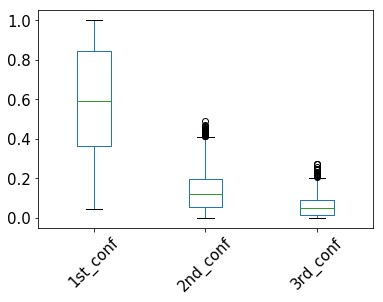

In [809]:
twitter_archive_master[['1st_conf','2nd_conf','3rd_conf']].boxplot(grid=False, rot=45, fontsize=15);

make visualization for sum of number of dogs for each level of prediction

In [810]:
Number_of_dogs = twitter_archive_master[['1st_is_dog','2nd_is_dog','3rd_is_dog']].sum()

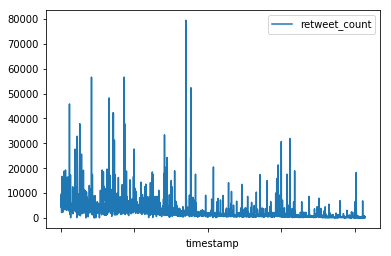

In [811]:
twitter_archive_master.plot(x = 'timestamp', y = 'retweet_count');

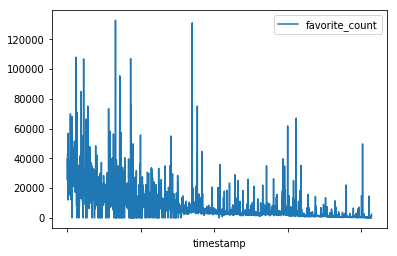

In [812]:
twitter_archive_master.plot(x = 'timestamp', y = 'favorite_count');